# DTU 46500 :  Extreme Winds
## Prediction of the 50-year maximum wind speed

### Author: Gonzalo Mazzini 


In [1]:
# Show plots in the notebook
%matplotlib inline 

# Automatically reload any packages that changed
%load_ext autoreload
%autoreload 2

# Display multiple arguments
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [2]:
############## python libraries for algebra, math and stats.
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import math as m
import chaospy as cp

################### 

from scipy import optimize
from scipy.stats import gumbel_r  
from numpy.polynomial import polynomial as P

##############
import matplotlib.pyplot as plt
import datetime
import seaborn as sns






In [3]:
Data = np.genfromtxt('Hovsore2004to2020_U+dir.csv',delimiter=',')
Dnames = ['Timestamp','Wsp','MeanDir']

In [4]:
df=pd.read_csv('Hovsore2004to2020_U+dir.csv',delimiter=',', names=['datetime','ws','wdir1'], parse_dates=['datetime'])
df.head()
df.describe()['ws']

,datetime,ws,wdir1
0,2004-02-27 00:06:00,5.23804,313.596985
1,2004-02-27 00:16:00,4.11642,307.200989
2,2004-02-27 00:26:00,3.93875,295.513000
3,2004-02-27 00:36:00,3.34926,287.860992
4,2004-02-27 00:46:00,2.90978,283.510010


count    852994.000000
mean          9.219035
std           4.426838
min           0.510970
25%           5.991935
50%           8.792115
75%          11.946700
max          40.595699
Name: ws, dtype: float64

In [5]:
df.head()
df.describe()['ws']

,datetime,ws,wdir1
0,2004-02-27 00:06:00,5.23804,313.596985
1,2004-02-27 00:16:00,4.11642,307.200989
2,2004-02-27 00:26:00,3.93875,295.513000
3,2004-02-27 00:36:00,3.34926,287.860992
4,2004-02-27 00:46:00,2.90978,283.510010


count    852994.000000
mean          9.219035
std           4.426838
min           0.510970
25%           5.991935
50%           8.792115
75%          11.946700
max          40.595699
Name: ws, dtype: float64

In [6]:
# CREATE A DATETIME ARRAY SO WE CAN USE TIME-DELTAS LATER
T = np.empty(Data[:,0].shape, dtype = datetime.datetime) # Empty numpy array of type datetime
for i in range(len(Data[:,0])):
    T[i] = datetime.datetime.strptime(str(Data[i,0].astype('int64')),'%Y%m%d%H%M')

In [7]:
# CREATE FILTERS (by using Boolean masks)
someLowWindSpeed=1
CrazyWind=45
tooBig_dUdt=5

WspOK = ((Data[:,1] > someLowWindSpeed)&(Data[:,1] < CrazyWind)) # Boolean array (T or F) to reject unrealistic wind speeds
DeltaU = np.diff(Data[:,1])
DeltaT = np.diff(T)
dUdT = np.empty(DeltaU.shape,dtype = 'float')
for i in range(len(DeltaU)):
    dUdT[i] = DeltaU[i]/(DeltaT[i].seconds/600) # Change of wind speed over 10 minutes

maxDeltaU = tooBig_dUdt  # Filter: limit largest change allowed in wind speed over 10min
DeltaUOK = (dUdT > -maxDeltaU) & (dUdT < maxDeltaU) 

OK1 = (WspOK[0:-1]==True) & (DeltaUOK == True)
OK2 = (WspOK[1:]==True) & (DeltaUOK == True)
OK1 = np.append(OK1,True)
OK2 = np.insert(OK2,0,True)

DataOK = OK1 & OK2 # Final filter in terms of a Boolean array


C:\Users\Usuario\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
C:\Users\Usuario\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
C:\Users\Usuario\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
C:\Users\Usuario\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


In [8]:
# APPLY FILTERS AND COMPUTE YEAR/MONTH VALUES 
T = T[DataOK]
Timestamp = Data[DataOK,0]
Wsp = Data[DataOK,1]
TI = Data[DataOK,2]

# Compute year and month
Year = np.floor(Timestamp/1e8).astype('int64')
Month = np.floor(np.mod(Timestamp,1e8)/1e6).astype('int64')
#Day = np.floor(np.mod(Timestamp,1e6)/1e4).astype('int64')
#Hour = np.floor(np.mod(Timestamp,1e4)/1e2).astype('int64')
#Minute = np.floor(np.mod(Timestamp,1e2)/1).astype('int64')

<Figure size 864x432 with 0 Axes>

Text(0, 0.5, '10-minute average Wind Speed [m/s] ')

Text(0.5, 0, 'Time [years]')

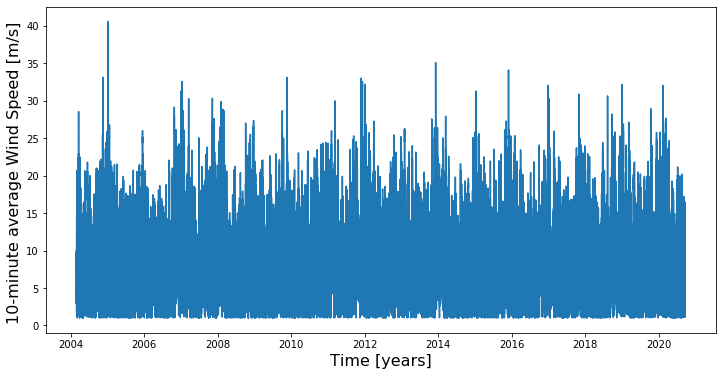

In [131]:
# plot the filtered data to check it:
plt.figure(figsize=(12,6))
plt.plot(T,Wsp)
plt.ylabel('10-minute average Wind Speed [m/s] ', fontsize=16)
plt.xlabel('Time [years]', fontsize=16)
plt.show()

In [10]:
# COMPUTE ANNUAL MAXIMA

Years = np.unique(Year)

nyears = round(len(T)/(6*24*365))   #6 PORQUE 1 HOUR SON 10 TIMESTEMPS
Umax = np.empty(nyears,dtype = 'float')

for i in range(nyears):
    CurrentPeriod = ((Year==Years[i]) & (Month >= 10)) | ((Year == (Years[i]+1)) & (Month < 10))
    Umax[i] = max(Wsp[CurrentPeriod])

In [11]:
print('Annual maxima: ' + str(Umax))

Annual maxima: [40.59569931 26.01259995 32.57329941 30.33069992 27.38129997 33.12639999
 29.99119949 33.03359985 26.29520035 35.10079956 31.30369949 34.11059952
 32.05699921 30.89279938 32.19820023 32.06420135]


## GUMBEL FIT - METHOD OF Probability-weighted moments (PWM)

Calculate the expected 50-year maximum wind,
– using yearly maxima U1, fitting a Gumbel distribution, using PWM, 
#### based on all data.

In [12]:
UmaxSorted = np.sort(Umax)

b0PWM = b0PWM = 1/len(UmaxSorted)*np.sum(UmaxSorted)

N=len(UmaxSorted)
factores=np.empty(N)

for i in range (1,N+1):
    factores[i-1]=(i-1)/(N-1)


b1PWM = (1/len(UmaxSorted))*(np.sum(factores*UmaxSorted))

alphaPWM = (2*b1PWM-b0PWM)/m.log(2)

betaPWM = b0PWM-0.577

V50PWM=betaPWM-alphaPWM*m.log(-m.log(1-1/50))

#V50PWM_aprox = betaPWM+alphaPWM*m.log(50)

In [13]:
print('PWM: V50= '+str(V50PWM.round(1))+' m/s; alpha='+str(alphaPWM.round(2))+', beta='+str(betaPWM.round(1))+' m/s')

PWM: V50= 42.0 m/s; alpha=2.8, beta=31.1 m/s


In [14]:
# no correr, resultados de la notebook.
print('PWM: V50= '+str(V50PWM.round(1))+' m/s; alpha='+str(alphaPWM.round(2))+', beta='+str(betaPWM.round(1))+' m/s')

PWM: V50= 42.0 m/s; alpha=2.8, beta=31.1 m/s


# Using 7 different 2-year chunks (e.g. 2011-12, 2009-10…)

In [15]:
def get_year(col): 
    return col.year

df['year']=df['datetime'].apply(get_year)

In [16]:
duoyears=[(2005,2006, '2005/6'),(2007,2008, '2007/8' ),(2009,2010, '2009/10'),(2011,2012, '2011/12'),
          (2013,2014, '2013/14'),(2015,2016, '2015/16'), (2017,2018, '2017/18')  ]
duoyears_dict={}

for element in duoyears:
  
    duoyears_dict[element[2]]=element[:2]

for tupla in duoyears:
    duoyears_dict[tupla[2]]=np.asarray([max(df[(df['year']==tupla[:2][0])]['ws']),
                                        max(df[(df['year']==tupla[:2][1])]['ws'])])

In [17]:
maximasdict={}
alphaPWM2_list=[]
betaPWM2_list=[]
velocitiesPWM2_list=[]
for key , valoresduo in duoyears_dict.items():
    ValoresSorted = np.sort(valoresduo)

    b0PWM2 = b0PWM2 = 1/len(ValoresSorted)*np.sum(ValoresSorted)
    
    N=len(valoresduo)
    factoresduo=np.empty(N)

    for i in range (1,N+1):
        factoresduo[i-1]=(i-1)/(N-1)


    b1PWM2 = (1/len(ValoresSorted))*(np.sum(factoresduo*ValoresSorted))

    alphaPWM2 = (2*b1PWM2-b0PWM2)/m.log(2)

    betaPWM2 = b0PWM2-0.577
    
    maximasdict[key]= (betaPWM2-alphaPWM2*m.log(-m.log(1-1/50)) , alphaPWM2 , betaPWM2 )
    alphaPWM2_list.append(alphaPWM2)
    betaPWM2_list.append(betaPWM2)
    velocitiesPWM2_list.append(betaPWM2-alphaPWM2*m.log(-m.log(1-1/50)))
    
for k in maximasdict.keys():
    print(maximasdict[k])   # (v50 , alpha , beta)

(66.50412319768539, 8.254018397307052, 34.297449729919435)
(38.19933824641471, 1.9331386542850384, 30.656349800109865)
(52.64938985907979, 6.264037413120044, 28.207500122070314)
(34.38609313604495, 0.6013146370318965, 32.03980030822754)
(66.05453083948045, 8.418630559684484, 33.20555081176758)
(42.16776740492041, 2.3259126323255206, 33.092198989868166)
(30.872242872718157, 0.17341217065678544, 30.19559922027588)


In [19]:
print(f'the CV of V50 is: {np.std(np.asarray(velocitiesPWM2_list))/np.mean(np.asarray(velocitiesPWM2_list))}')
print(f'the CV of alpha is: {np.std(np.asarray(alphaPWM2_list))/np.mean(np.asarray(alphaPWM2_list))}')
print(f'the CV of beta is: {np.std(np.asarray(betaPWM2_list))/np.mean(np.asarray(alphaPWM2_list))}')

the CV of V50 is: 0.2877823510038487
the CV of alpha is: 0.8247058558851043
the CV of beta is: 0.4879557153655043


# GUMBEL FIT - other method (e.g. max-likelihood...)

In [20]:
gumb_likelihood= lambda x: -np.sum( np.log(gumbel_r.pdf(Umax, loc=x[0],scale=x[1]) ) )
gumb_opt = optimize.minimize(gumb_likelihood,[10,2])

In [21]:
30.04-3.09*m.log(-m.log(1-1/50))

42.096990453021725

In [22]:
gumb_opt.x

array([30.04518202,  3.09108672])

In [23]:
print(gumb_opt)

      fun: 42.579058829230995
 hess_inv: array([[0.69168938, 0.17899232],
       [0.17899232, 0.35746511]])
      jac: array([4.76837158e-07, 1.43051147e-06])
  message: 'Optimization terminated successfully.'
     nfev: 76
      nit: 15
     njev: 19
   status: 0
  success: True
        x: array([30.04518202,  3.09108672])


# How well does this follow a Gumbel distribution?

<Figure size 864x432 with 0 Axes>

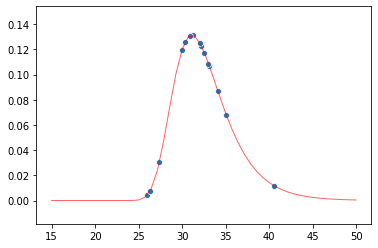

In [20]:
x_linsp=np.linspace(15,50,50)

fig=plt.figure(figsize=(12,6))
fig, ax=plt.subplots(1,1)
sns.scatterplot(x=Umax ,y=gumbel_r.pdf(Umax, loc=betaPWM, scale=alphaPWM))
ax.plot(x_linsp, gumbel_r.pdf(x_linsp, loc=betaPWM, scale=alphaPWM), 'r-', lw=1, alpha=0.6)

plt.show()

__Kolmogorov Test

In [24]:
gumb_opt.x

array([30.04518202,  3.09108672])

In [25]:
Kolmogorov_test_MLE= stats.kstest(Umax,'gumbel_r', gumb_opt.x)       

In [26]:
Kolmogorov_test_PWM = stats.kstest(Umax,'gumbel_r', np.asarray([betaPWM,alphaPWM]))  #for PWM

Kolmogorov_test_MLE= stats.kstest(Umax,'gumbel_r', gumb_opt.x)           

print(f'p-value for Kolmogorov Test with PWM method: {Kolmogorov_test_PWM}')
print(f'p-value for Kolmogorov Test with MLE method: {Kolmogorov_test_MLE}')
#Chequear resultados.

p-value for Kolmogorov Test with PWM method: KstestResult(statistic=0.19819172310045485, pvalue=0.5016826520000621)
p-value for Kolmogorov Test with MLE method: KstestResult(statistic=0.17395514737786738, pvalue=0.680637704772862)


The p-value represents the probability of the null hipotesis. For the Kolmogorov test, the null hipotesis is that the two samples have the same distribution. In this case, the One-way Kolmogorov Test (comparing a data sample to a theoretical reference distribution) the result is that the sample has the same distribution with a 0.8349 level of statistical significance for the Max Likelhood method and 0.6832 for MWP.

# Uncertainty in the 50-year wind

• Simulate Gumbel-distributed wind maxima for 1000 years,
• using the a-parameter you found previously (in 1a)
– do bootstrap-sampling with many 2-year segments: get 𝑓!"(𝑉#$) and 𝑓!"(𝛼),
i.e. distributions of 𝑉#$ and 𝛼 found when using PWM and only 2 years;
– what is the std.dev. of 𝑉#$ (𝜎%!"&'(), i.e. uncertainty),
in Gumbel-fitting using only 2 years?
– repeat for other segment lengths 𝑇)* (3 yr…10 yr.),
to get (fit) an expression for 𝜎%!"&'( -variation as a function of 𝑇)*
– Considering the expression to estimate Var{U_T} [slide 18]
what variation in ‘slope’ a does this 𝜎%!"(𝑇)*) correspond to?

As discussed in class, for the 1000 years you’ll synthesize 1000 annual maxima using a Gumbel distribution

In [27]:
# Monte Carlo

Text(0.5, 0, 'Samples')

Text(0, 0.5, 'Uniform distribution [0,1]')

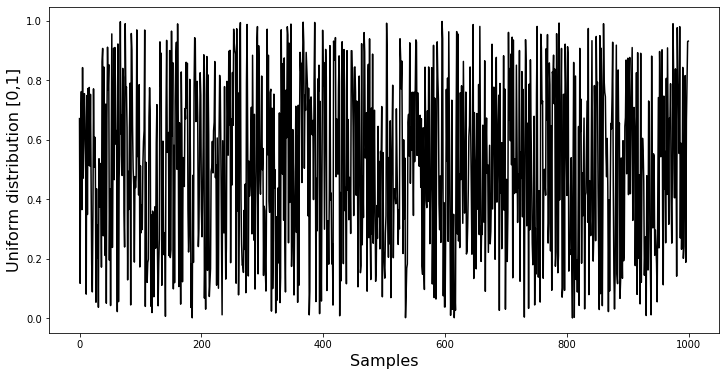

In [133]:
import chaospy as cp

MarginalDist1 = cp.Uniform(0,1)

N_samples=1000

SMC = MarginalDist1.sample(N_samples, rule = "R")

fig=plt.figure(figsize=(12,6))
plt.xlabel('Samples', fontsize=16)
plt.ylabel('Uniform distribution [0,1]', fontsize=16)

plt.plot(SMC, color='black')

X_dist=gumbel_r(loc=betaPWM, scale=alphaPWM)

In [31]:
type(gumbel_r(loc=betaPWM, scale=alphaPWM))

scipy.stats._distn_infrastructure.rv_frozen

In [32]:
X1_MC = X_dist.ppf(SMC)

Text(0, 0.5, 'Frecuency')

Text(0.5, 0, 'Wind annual maxima (simulated) [m/s]')

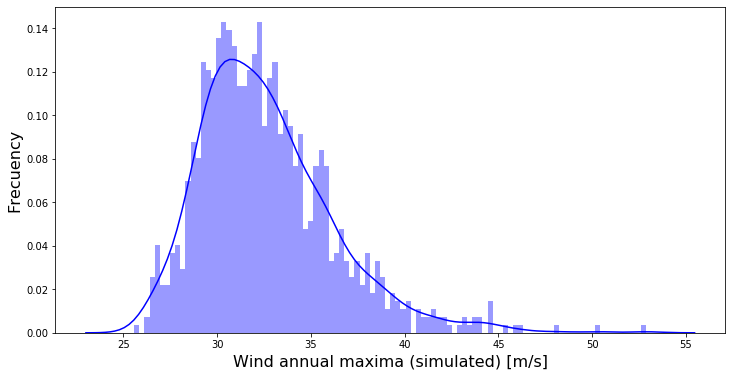

In [136]:
import seaborn as sns
fig=plt.figure(figsize=(12,6))
sns.distplot(X1_MC,bins=100, kde=True, color='b')
plt.ylabel('Frecuency', fontsize=16)
plt.xlabel('Wind annual maxima (simulated) [m/s]', fontsize=16)

In [34]:
X1_MC

array([36.76001662, 38.68937206, 35.17114294, 31.53363383, 33.59534482,
       26.62216142, 30.37954916, 30.64685561, 35.71870112, 30.90931385,
       38.80294514, 27.24539358, 33.19564317, 30.48400871, 31.83976444,
       30.58430445, 30.26728279, 31.24108062, 31.63456683, 29.98382318,
       35.44837089, 29.50085129, 33.40562006, 28.40462752, 29.20589377,
       28.45376012, 34.82976201, 28.6660048 , 37.20180924, 29.24280277,
       30.07104234, 38.02603796, 27.85070326, 32.86866144, 29.27760626,
       29.69315172, 30.11614088, 28.49941772, 33.21690264, 29.44629732,
       25.58471736, 39.13681513, 31.72002288, 29.35120502, 31.84123524,
       32.27988671, 38.28465468, 29.93093764, 29.32897651, 30.4389746 ,
       29.77017296, 44.54382804, 29.11835383, 28.66816231, 33.98177207,
       31.18922965, 37.33376879, 34.47607996, 34.26464627, 32.74111342,
       31.08209946, 32.3766808 , 28.22580593, 35.72865525, 27.79388998,
       31.51890865, 34.46061548, 31.11059995, 28.81158508, 29.04

In [48]:
X1_MC.sort()   #ESTO NO LO PIDE....

UMCmaxSorted = np.sort(X1_MC)

b0PWM_MC = b0PWM_MC = 1/len(UMCmaxSorted)*np.sum(UMCmaxSorted)

N=len(UMCmaxSorted)
factores_MC=np.empty(N)

for i in range (1,N+1):
    factores_MC[i-1]=(i-1)/(N-1)


b1PWM_MC = (1/len(UMCmaxSorted))*(np.sum(factores_MC*UMCmaxSorted))

alphaPWM_MC = (2*b1PWM_MC-b0PWM_MC)/m.log(2)

betaPWM_MC = b0PWM_MC-0.577

V50PWM_MC=betaPWM_MC-alphaPWM_MC*m.log(-m.log(1-1/50))

#V50PWM_aprox = betaPWM+alphaPWM*m.log(50)

print(f"the V max50years using all simulated velocities  {V50PWM_MC}")

the V max50years using all simulated velocities  44.213037518519315


__do bootstrap-sampling with many 2-year segments: get 𝑓!"(𝑉#$) and 𝑓!"(𝛼),i.e. distributions of 𝑉#$ and 𝛼 found when using PWM and only 2 years;

In [35]:
Nbootstrap = 2
BootstrapSize = 1000
Bsample = np.random.choice(X1_MC, size=(BootstrapSize, Nbootstrap))  #toma 1.000 muestras de 2 velocidades.

Bsample.shape

Bsample

(1000, 2)

In [37]:
bootstrap_output=[]
for dupla in Bsample:
    DuplaSorted = np.sort(dupla)

    b0PWMboot2 = b0PWMboot2 = 1/len(DuplaSorted)*np.sum(DuplaSorted)
    
    N=len(dupla)
    factoresboot2=np.empty(N)

    for i in range (1,N+1):
        factoresboot2[i-1]=(i-1)/(N-1)


    b1PWMboot2 = (1/len(DuplaSorted))*(np.sum(factoresboot2*DuplaSorted))

    alphaPWMboot2 = (2*b1PWMboot2-b0PWMboot2)/m.log(2)

    betaPWMboot2 = b0PWMboot2-0.577
    
    V50PWMboot2=betaPWMboot2-alphaPWMboot2*m.log(-m.log(1-1/50))
    
    bootstrap_output.append((V50PWMboot2,alphaPWMboot2,betaPWMboot2))
    

In [39]:
alphavalues_boot2=np.asarray([bootstrap_output[k][1] for k in range(0,1000)])

In [40]:
np.mean(alphavalues_boot2)

2.6827194452364918

<Figure size 864x432 with 0 Axes>

Text(0.5, 0, 'Values of α for two-years bootstrap sampling')

Text(0, 0.5, 'Frecuency ')

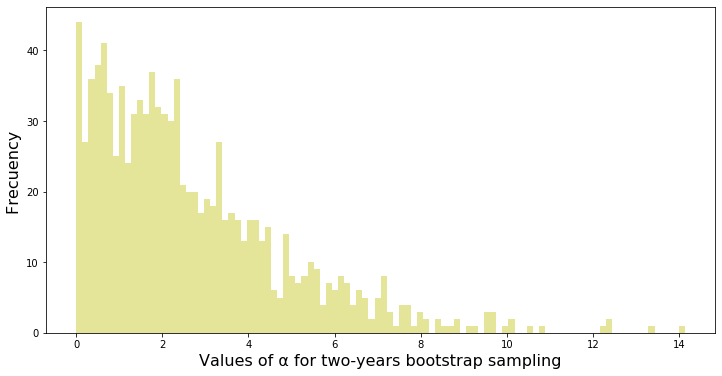

In [41]:
plt.figure(figsize=(12,6))
sns.distplot(alphavalues_boot2,bins=100, kde=False, color='y')
plt.xlabel('Values of α for two-years bootstrap sampling', fontsize=16)
plt.ylabel('Frecuency ', fontsize=16)

In [42]:
velocities_boot2=np.asarray([bootstrap_output[k][0] for k in range(0,1000)])

np.mean(velocities_boot2)

<Figure size 864x432 with 0 Axes>

Text(0.5, 0, ' V50 max using two-year bootstrap sampling')

Text(0, 0.5, 'Frecuency ')

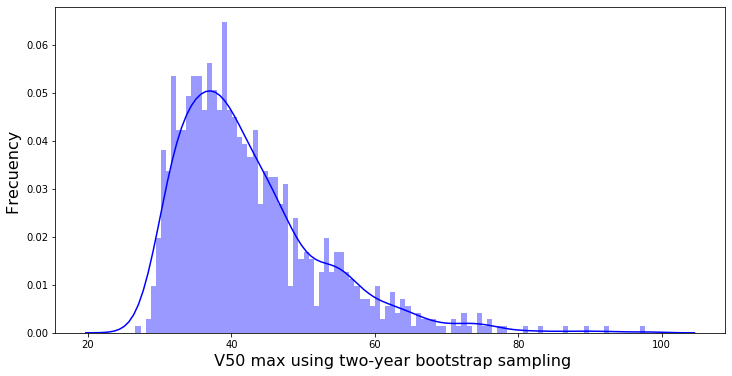

In [137]:
plt.figure(figsize=(12,6))
sns.distplot(velocities_boot2,bins=100, kde=True,  color='b')
plt.xlabel(' V50 max using two-year bootstrap sampling', fontsize=16)
plt.ylabel('Frecuency ', fontsize=16)


In [392]:
# X_dist=gumbel_r(loc=betaPWM, scale=alphaPWM)

#### What is the std.dev. of 𝑉50 ( i.e. uncertainty),in Gumbel-fitting using only 2 years?

In [42]:
np.std(velocities_boot2)

11.11092082928754

#### Repeat for other segment lengths 𝑇)* (3 yr…10 yr.), to get (fit) an expression for 𝜎v50 '( -variation as a function of 𝑇)*

In [45]:
diffLenBoots=[]
for Nbootstrap in [2,3,4,5,6,7,8,9,10,20,30,50]:
    BootstrapSize = 1000
    Bsample = np.random.choice(X1_MC, size=(BootstrapSize, Nbootstrap))
    diffLenBoots.append(Bsample)

In [46]:
diffLenBoots[0].shape  #(1000, 2)
diffLenBoots[1].shape  #(1000, 3)
diffLenBoots[2].shape  #(1000, 4)

(1000, 2)

(1000, 3)

(1000, 4)

In [47]:
boot_element

array([32.16756534])

In [47]:
stdVel_bootstrap=[]
bootset_output=[]
for boot_set in diffLenBoots:
    
    for boot_element in boot_set:  #entra aca a iterar las 1000 muestras de tamañao 2 primero.
    
        TSorted = np.sort(boot_element)

        b0PWM_mb = b0PWM = 1/len(TSorted)*np.sum(TSorted)

        N=len(TSorted)
        factores_mb=np.empty(N)

        for i in range (1,N+1):
            factores_mb[i-1]=(i-1)/(N-1)

        b1PWM_mb = (1/len(TSorted))*(np.sum(factores_mb*TSorted))

        alphaPWM_mb = (2*b1PWM_mb-b0PWM_mb)/m.log(2)

        betaPWM_mb = b0PWM_mb-0.577

        V50PWM_mb=betaPWM_mb-alphaPWM_mb*m.log(-m.log(1-1/50))

        bootset_output.append(V50PWM_mb) #para el primer bootset (1000,3), voy a tener 1.000 V50.
        
        if len(bootset_output)==1000:
        
            vel_mb=np.asarray([bootset_output])  #convierto en array al bootset para calcular std
            
            stdVel_bootstrap.append(np.std(vel_mb))
                                    
            bootset_output=[]  #reinicio bootset_output [no hace falta reiniciar vel_mb porque se iguala al nuevo valor]
                                    
                                    
# [k] for k in range(0,1000)
    

In [48]:
np.asarray(stdVel_bootstrap)  #quiero el alpha que ajuste la expresion lo mas cercano a estos valores

array([10.36632877,  8.37761747,  6.44915801,  5.90795249,  5.16004528,
        4.87324066,  4.59772351,  4.33811303,  4.0227292 ,  2.7417995 ,
        2.18311093,  1.76330892])

In [49]:
from numpy.polynomial import polynomial as P

In [147]:
x=[2,3,4,5,6,7,8,9,10,20,30,50]          #Cambiar aca 
y=np.asarray(stdVel_bootstrap)
c, stats = P.polyfit(x,y,5, full=True)

In [82]:
pol_aprox_6=[]
for x in [2,3,4,5,6,7,8,9,10,20,30,50]:
    y=c[0]+c[1]*x+c[2]*x**2+c[3]*x**3+c[4]*x**4+c[5]*x**5+c[6]*x**6
    pol_aprox_6.append(y)

In [146]:
-5.36028520e-06

-5.3602852e-06

In [148]:
c

array([ 1.63025174e+01, -3.83442353e+00,  4.59885678e-01, -2.53497228e-02,
        6.19403545e-04, -5.36028520e-06])

In [85]:
pol_aprox_5=[]
for x in [2,3,4,5,6,7,8,9,10,20,30,50]:
    y=c[0]+c[1]*x+c[2]*x**2+c[3]*x**3+c[4]*x**4+c[5]*x**5
    pol_aprox_5.append(y)

In [57]:
pol_aprox_4=[]
for x in [2,3,4,5,6,7,8,9,10,20,30,50]:
    y=c[0]+c[1]*x+c[2]*x**2+c[3]*x**3+c[4]*x**4
    pol_aprox_4.append(y)

In [59]:
pol_aprox_3=[]
for x in [2,3,4,5,6,7,8,9,10,20,30,50]:
    y=c[0]+c[1]*x+c[2]*x**2+c[3]*x**3
    pol_aprox_3.append(y)

In [61]:
pol_aprox_2=[]
for x in [2,3,4,5,6,7,8,9,10,20,30,50]:
    y=c[0]+c[1]*x+c[2]*x**2
    pol_aprox_2.append(y)

Text(0.5, 0, 'T_es [years]')

Text(0, 0.5, 'Std. (σ) of V_50 [m/s]')

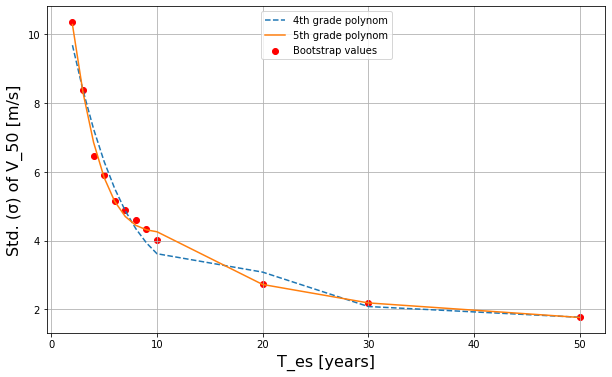

In [118]:
fig1, ax1=plt.subplots(1,1, figsize=(10,6))
ax1.scatter([2,3,4,5,6,7,8,9,10,20,30,50],stdVel_bootstrap, color='red', label='Bootstrap values')
#ax1.plot([2,3,4,5,6,7,8,9,10,20,30,50],np.asarray(pol_aprox_2),linestyle='-', label='2th grade polynom' )
#ax1.plot([2,3,4,5,6,7,8,9,10,20,30,50],np.asarray(pol_aprox_3),linestyle='-', label='3th grade polynom' )
ax1.plot([2,3,4,5,6,7,8,9,10,20,30,50],np.asarray(pol_aprox_4), linestyle='--', label='4th grade polynom')
ax1.plot([2,3,4,5,6,7,8,9,10,20,30,50],np.asarray(pol_aprox_5), linestyle='-' ,label='5th grade polynom')
plt.xlabel('T_es [years]', fontsize=16)
plt.ylabel('Std. (σ) of V_50 [m/s]',  fontsize=16)

leg = ax1.legend(loc='upper center')
plt.grid()

In [112]:
np.mean(abs(np.asarray(pol_aprox_6)-np.asarray(stdVel_bootstrap)))

np.mean(abs(np.asarray(pol_aprox_5)-np.asarray(stdVel_bootstrap)))

np.mean(abs(np.asarray(pol_aprox_4)-np.asarray(stdVel_bootstrap)))

np.mean(abs(np.asarray(pol_aprox_3)-np.asarray(stdVel_bootstrap)))

np.mean(abs(np.asarray(pol_aprox_2)-np.asarray(stdVel_bootstrap)))

0.06748552368000826

0.10669551904306866

0.3130240194362509

0.5130615976420355

0.9356973735320656

In [124]:
stdVel_bootstrap  #esto es para los siguientes valores de Tes [2,3,4,5,6,7,8,9,10,20,30,50]
for tes in [2,3,4,5,6,7,8,9,10,20,30,50]:
    

[11.455281272605415,
 8.09122701542229,
 6.914407886742717,
 6.406916275915872,
 5.591351218550368,
 5.257116436982531,
 4.753157220330781,
 4.627347031038861,
 4.307592266857092,
 2.887097708154548,
 2.409042458817451,
 1.8676495608965242]

In [87]:
varU_T_teorical=[]
alpha_varU_T_dict={}
for alpha in [0.5,1,2,3]:
    for N in [2,3,4,5,6,7,8,9,10,20,30,50]:
        qt=(m.log(50)-0.577)/m.log(2)
        var_N=((alpha**2*m.pi**2)/(6*N))*(1+0.584*qt+(0.234*qt**2)/(1-0.823/N))
        varU_T_teorical.append(np.sqrt(var_N))
    alpha_varU_T_dict[alpha]=varU_T_teorical #almaceno la lista en el diccionario
    varU_T_teorical=[]   #reinicio

In [95]:
np.asarray(alpha_varU_T_dict[2])

array([6.54344497, 4.97276499, 4.18162383, 3.68058196, 3.32608106,
       3.05800083, 2.84600377, 2.67286896, 2.52798629, 1.76409075,
       1.43429495, 1.10731367])

Text(0.5, 0, 'T_es [years]')

Text(0, 0.5, 'Std. (σ) of V_50 [m/s]')

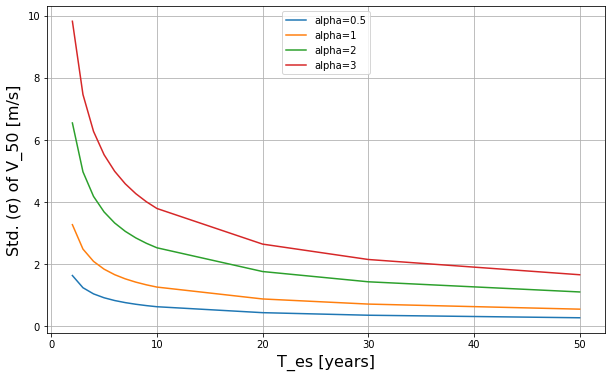

In [119]:
fig1, ax1=plt.subplots(1,1, figsize=(10,6))
ax1.plot([2,3,4,5,6,7,8,9,10,20,30,50],[1.63586124, 1.24319125, 1.04540596, 0.92014549, 0.83152027,
       0.76450021, 0.71150094, 0.66821724, 0.63199657, 0.44102269,
       0.35857374, 0.27682842], label='alpha=0.5')

ax1.plot([2,3,4,5,6,7,8,9,10,20,30,50],[3.27172248, 2.4863825 , 2.09081191, 1.84029098, 1.66304053,
       1.52900041, 1.42300189, 1.33643448, 1.26399315, 0.88204538,
       0.71714748, 0.55365683], label='alpha=1')

ax1.plot([2,3,4,5,6,7,8,9,10,20,30,50],[6.54344497, 4.97276499, 4.18162383, 3.68058196, 3.32608106,
       3.05800083, 2.84600377, 2.67286896, 2.52798629, 1.76409075,
       1.43429495, 1.10731367], label='alpha=2')


ax1.plot([2,3,4,5,6,7,8,9,10,20,30,50],[9.81516745, 7.45914749, 6.27243574, 5.52087294, 4.98912159,
       4.58700124, 4.26900566, 4.00930344, 3.79197944, 2.64613613,
       2.15144243, 1.6609705 ], label='alpha=3')

#ax1.scatter([2,3,4,5,6,7,8,9,10,20,30,50],[10.36632877,  8.37761747,  6.44915801,  5.90795249,  5.16004528,
      #  4.87324066,  4.59772351,  4.33811303,  4.0227292 ,  2.7417995 ,
  #      2.18311093,  1.76330892])

plt.xlabel('T_es [years]', fontsize=16)
plt.ylabel('Std. (σ) of V_50 [m/s]',  fontsize=16)
plt.grid()
leg = ax1.legend(loc='upper center')

In [101]:
np.linspace(3,3.5,21)

array([3.   , 3.025, 3.05 , 3.075, 3.1  , 3.125, 3.15 , 3.175, 3.2  ,
       3.225, 3.25 , 3.275, 3.3  , 3.325, 3.35 , 3.375, 3.4  , 3.425,
       3.45 , 3.475, 3.5  ])

In [102]:
#find alpha that minimieze the error between the obtained values and 
find_varU_T_teorical=[]
find_alpha_varU_T_dict={}
for alpha in np.linspace(3,3.5,21):
    for N in [2,3,4,5,6,7,8,9,10,20,30,50]:
        qt=(m.log(50)-0.577)/m.log(2)
        var_N=((alpha**2*m.pi**2)/(6*N))*(1+0.584*qt+(0.234*qt**2)/(1-0.823/N))
        find_varU_T_teorical.append(np.sqrt(var_N))
    find_alpha_varU_T_dict[alpha]=find_varU_T_teorical #almaceno la lista en el diccionario
    find_varU_T_teorical=[]   #reinicio


In [103]:
mindif_list=[]
for k, v in find_alpha_varU_T_dict.items():
    print(k , np.mean(abs(np.asarray(v)-np.asarray(stdVel_bootstrap))) )
    mindif_list.append(np.mean(abs(np.asarray(v)-np.asarray(stdVel_bootstrap))))

3.0 0.30071197713102094
3.025 0.26100879376846003
3.05 0.22200375466193434
3.075 0.18528868578083646
3.1 0.15396677002786943
3.125 0.13455486393061536
3.15 0.1171560359646221
3.175 0.10332222762182885
3.2 0.10788932304170668
3.225 0.12256470282900855
3.25 0.14579891622649185
3.275 0.17514217251923822
3.3 0.20448542881198506
3.325 0.23382868510473212
3.35 0.26317194139747907
3.375 0.29483577330739213
3.4 0.33453895666995237
3.425 0.3742421400325133
3.45 0.4139453233950748
3.475 0.45364850675763585
3.5 0.4933516901201962


In [104]:
min(mindif_list)  #0.103322  equal to 3.175

0.10332222762182885

In [107]:
np.asarray(find_alpha_varU_T_dict[3.175])

array([10.38771889,  7.89426443,  6.63832782,  5.84292386,  5.28015368,
        4.85457631,  4.51803099,  4.24317948,  4.01317824,  2.80049407,
        2.27694323,  1.75786045])

Text(0.5, 0, 'T_es [years]')

Text(0, 0.5, 'Std. (σ) of V_50 [m/s]')

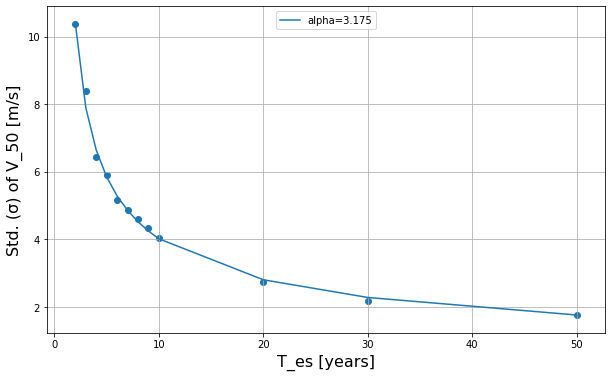

In [110]:
fig1, ax1=plt.subplots(1,1, figsize=(10,6))
ax1.plot([2,3,4,5,6,7,8,9,10,20,30,50],np.asarray(find_alpha_varU_T_dict[3.175]), label='alpha=3.175')

ax1.scatter([2,3,4,5,6,7,8,9,10,20,30,50],[10.36632877,  8.37761747,  6.44915801,  5.90795249,  5.16004528,
        4.87324066,  4.59772351,  4.33811303,  4.0227292 ,  2.7417995 ,
        2.18311093,  1.76330892])

plt.xlabel('T_es [years]', fontsize=16)
plt.ylabel('Std. (σ) of V_50 [m/s]',  fontsize=16)
plt.grid()
leg = ax1.legend(loc='upper center')

In [120]:
find_varU_T_teorical=[]
find_alpha_varU_T_dict={}
for alpha in np.linspace(3.15,3.2,21):
    for N in [2,3,4,5,6,7,8,9,10,20,30,50]:
        qt=(m.log(50)-0.577)/m.log(2)
        var_N=((alpha**2*m.pi**2)/(6*N))*(1+0.584*qt+(0.234*qt**2)/(1-0.823/N))
        find_varU_T_teorical.append(np.sqrt(var_N))
    find_alpha_varU_T_dict[alpha]=find_varU_T_teorical #almaceno la lista en el diccionario
    find_varU_T_teorical=[]   #reinicio

In [121]:
mindif_list=[]
for k, v in find_alpha_varU_T_dict.items():
    print(k , np.mean(abs(np.asarray(v)-np.asarray(stdVel_bootstrap))) )
    mindif_list.append(np.mean(abs(np.asarray(v)-np.asarray(stdVel_bootstrap))))

3.15 0.1171560359646221
3.1525 0.11541615316802284
3.155 0.11367627037142347
3.1574999999999998 0.11193638757482427
3.16 0.11019650477822442
3.1625 0.10845662198162526
3.165 0.10671673918502599
3.1675 0.10497685638842662
3.17 0.10407555781208398
3.1725 0.10369889271695655
3.175 0.10332222762182885
3.1775 0.1029455625267014
3.18 0.10256889743157387
3.1825 0.1021922323364464
3.185 0.10234507790730989
3.1875 0.10280046020009902
3.19 0.1038182327684205
3.1925000000000003 0.10483600533674219
3.1950000000000003 0.10585377790506356
3.1975000000000002 0.1068715504733852
3.2 0.10788932304170668


In [124]:
np.asarray(find_alpha_varU_T_dict[3.1825])

array([10.4122568 ,  7.9129123 ,  6.65400891,  5.85672604,  5.29262649,
        4.86604381,  4.5287035 ,  4.25320273,  4.02265818,  2.80710941,
        2.28232184,  1.76201287])

Text(0.5, 0, 'T_es [years]')

Text(0, 0.5, 'Std. (σ) of V_50 [m/s]')

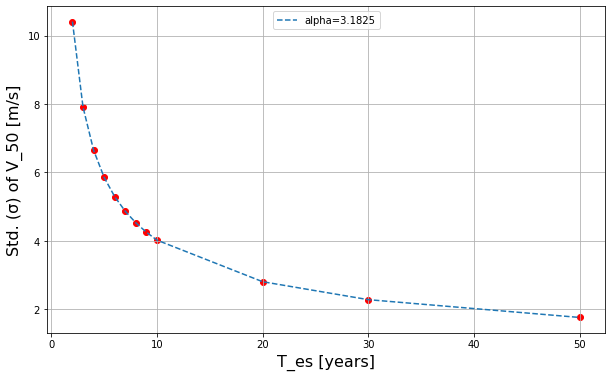

In [129]:
fig1, ax1=plt.subplots(1,1, figsize=(10,6))
ax1.scatter([2,3,4,5,6,7,8,9,10,20,30,50],np.asarray(find_alpha_varU_T_dict[3.1825]), color='r')
ax1.plot([2,3,4,5,6,7,8,9,10,20,30,50],np.asarray(find_alpha_varU_T_dict[3.1825]),linestyle='--', label='alpha=3.1825')



plt.xlabel('T_es [years]', fontsize=16)
plt.ylabel('Std. (σ) of V_50 [m/s]',  fontsize=16)
plt.grid()
leg = ax1.legend(loc='upper center')